# Preprocessing:

Step 1: checking Duplicates

In [5]:
import numpy as np
np.int = int
from pathlib import Path

# List of target composers
target_composers = ['Bach', 'Beethoven', 'Chopin', 'Mozart']
dataset_folder = Path('../data/midi/archive/midiclassics')

dataset = []         # [(file_path, composer)]
seen_filenames = {}  # filename -> path of first occurrence
duplicates = []      # [(filename, duplicate_path, original_path)]

for composer in target_composers:
    composer_folder = dataset_folder / composer

    for file_path in composer_folder.rglob('*'):
        if file_path.suffix.lower() in ['.mid', '.midi']:
            fname = file_path.name

            if fname not in seen_filenames:
                seen_filenames[fname] = str(file_path)
                dataset.append((str(file_path), composer))
            else:
                duplicates.append((fname, str(file_path), seen_filenames[fname]))

# Summary
print(f"Total unique MIDI files: {len(dataset)}")
print(f"Total duplicates found: {len(duplicates)}\n")

if duplicates:
    print("Duplicate files found (filename, duplicate path, original path):\n")
    for fname, dup_path, orig_path in duplicates:
        print(f"{fname}\n  DUP: {dup_path}\n  ORIG: {orig_path}\n")
else:
    print("No duplicates found.")


Total unique MIDI files: 1630
Total duplicates found: 0

No duplicates found.


In [ ]:
from pathlib import Path
from tqdm import tqdm
import pretty_midi
import numpy as np

# Compatibility for older NumPy versions
if not hasattr(np, 'int'):
    np.int = int

target_composers = ['Bach', 'Beethoven', 'Chopin', 'Mozart']

# We’re making a function that takes in the file path of a MIDI file and gives us back a numeric array of features
def midi_to_feature_array(midi_path):

    try:
        # using the pretty_midi library
        pm = pretty_midi.PrettyMIDI(str(midi_path))  # pm will be an object containing all the instruments, notes, tempos, and other music data from that file(PrettyMIDI needs a string, not a path obj)

        # Corrupted files, wrong format will be skipped
    except Exception as e: 
        print(f"Error reading {midi_path}: {e}")
        return None

    # making an empty list rows to hold all the note data we care about
    rows = []
    for inst in pm.instruments: #  we loop over every instrument in the MIDI file.

        #--- preprocessing 1 ----
        if inst.is_drum:
            continue  # drop drums (we want pitched musical notes like C or D,..) 
        # --- feature extraction ----
        for n in inst.notes:
            # keep the raw fields we need (note start/end, pitch, velocity, instrument program)
            rows.append([n.start, n.end, n.pitch, n.velocity, inst.program])
                #region each notes contains
                # n.start -> when the note starts (in seconds).
                # n.end -> when the note ends (in seconds).
                # n.pitch -> the MIDI pitch number (e.g., 60 = Middle C).
                # n.velocity -> how hard the note is played (volume).
                # inst.program -> the MIDI instrument number (0 = piano, 40 = violin, etc.).          
                #endregion each notes contains

    if not rows:
        return None  # nothing useful in this file

    # We convert the list of notes into a NumPy array
    # sorted by x[0] -> start time (so earlier notes come first)
    # then by x[2] -> pitch (so if two notes start at the same time, sort by pitch)
    # This gives us a consistent order for all notes
    notes = np.array(sorted(rows, key=lambda x: (x[0], x[2])), dtype=np.float32)

    # unpack columns for readability
    starts, ends, pitch, vel, prog = notes.T
    dur = ends - starts  # note duration( We calculate how long each note lasts).

    # --- preprocessing 2 ----
    # filtering out very short notes (less than 0.0001 seconds).
    # remove ultra-short/invalid notes (cleanup)
    # MIDI data often contains ultra-short notes that come from bad noisy conversion from another format, or human input glitches.
    # These “blips” don’t have real musical meaning and can add noise to our  features, making the model’s job harder.
    keep = dur > 1e-4
    if not np.any(keep):
        return None
    # Look at the duration of each note. If it’s long enough, keep that note’s other features (start, pitch, velocity, program) as well. If it’s too short, throw away the whole note row
    starts, dur, pitch, vel, prog = starts[keep], dur[keep], pitch[keep], vel[keep], prog[keep]

    
    # --- feature engineering  ----
    # turning the cleaned data into model-friendly numbers
    
    # time gap between this note and the previous note
    dt = np.diff(starts, prepend=starts[0])
    dt = np.log1p(dt)  # We take the logarithm of the gaps. Because musical timing can vary the can be tiny gaps vs. long pauses.  logs compress the range so big gaps don’t dominate.

    #  pitch change between this note and the previous note.
    interval = np.diff(pitch, prepend=pitch[0]) # Positive = up in pitch, negative = down
    interval = np.clip(interval, -24, 24)  # We limit (clip) pitch changes to ±24 semitones (two octaves) because large jumps are rare, and extreme values can mess with training

    # pc = pitch class -> the position of the note within an octave (0 = C, 1 = C#, … 11 = B).
    # This ignores octave number and focuses on note's name.
    pc = np.mod(pitch, 12)

    # duration relative to time until next note (captures staccato/legato feel)
    tnext = np.r_[starts[1:], starts[-1] + dur[-1]]           # tnext = when the next note starts, For the last note, we pretend the “next start” is at the note’s end.
    time_to_next = np.clip(tnext - starts, 1e-3, None)        # time until the next note, We clip at 1e-3 so we don’t divide by zero later
    dur_ratio = np.clip(dur / time_to_next, 0., 3.)           #  note length relative to the gap until the next note.  Near 1 = legato (notes connected). We clip to [0, 3] to avoid extreme values.

    # We stack all our engineered features into a single 2D array
    # plus useful raw-ish signals (velocity, program)
    #dt -> time gap to previous note
    #interval -> pitch change
    #pc -> pitch class
    #dur_ratio -> duration relative to next note #
    feats = np.stack([dt, interval, pc, dur_ratio, vel, prog], axis=1).astype(np.float32)
    return feats

    # Why we ignored pitch?
    # later on we found out using pitch feature dropped the accuracy ( Test Accuracy: dropped from 0.8296 to 0.7996)
    # THis 6‑feature set (pc‑based) was cleaner and simpler.
    # The new file balanced_chunks_seq70_7features.pkl is not “worse code,” but it changes the learning problem—more noise/features without compensating changes (tuning, capacity, or normalization strategies).
    


# Look through a root folder to load every MIDI file for that composer to convert them into feature arrays using midi_to_feature_array
def load_midi_dataset(root_dir, target_composers):
    

    data_dict = {} # Keys will be composer names and values will be lists of feature arrays (one per MIDI file for that composer).
    root_dir = Path(root_dir) # Path gives us nice methods like .rglob() for finding files
    for composer in target_composers: 
        composer_folder = root_dir / composer # making the full path to this composer’s folder.
        if not composer_folder.exists():
            print(f"Warning: Folder not found for {composer}")
            continue

        pieces = [] # empty list to hold all the processed pieces for this composer

        # We search recursively inside this composer’s folder for files ending in .mid or .midi.
        # .rglob("*.mid") finds all .mid files in all subfolders.
        midi_files = list(composer_folder.rglob("*.mid")) + list(composer_folder.rglob("*.midi"))

        for file_path in tqdm(midi_files, desc=f"Processing {composer}"): #  wrap the loop with tqdm so we get a nice progress bar in the terminal.
            arr = midi_to_feature_array(file_path)   # calling midi_to_feature_array to actually load it, clean it, and convert it into a numeric feature array for the model.
            if arr is not None:
                pieces.append(arr)

        data_dict[composer] = pieces # storing the list of that composer’s pieces into our main dictionary under their name.
        # at final we have 2D arrays looks like 
        # [ [dt, interval, pc, dur_ratio, vel, prog, pitch],   # note 1
        # [dt, interval, pc, dur_ratio, vel, prog, pitch],   # note 2
        # ...
        # ]

        print(f"Loaded {len(pieces)} pieces for {composer}")
    return data_dict




In [6]:
# the root directory of all our MIDI data
dataset_folder = Path("../data/midi/archive/midiclassics")
# Calling the above preprocessing and feature engineering functions 
parsed_data = load_midi_dataset(dataset_folder, target_composers)

Processing Bach:   4%|▍         | 42/1024 [00:02<00:46, 21.05it/s]c:\Users\azizi\anaconda3\envs\a511_2\lib\site-packages\pretty_midi\pretty_midi.py:97: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
Processing Bach: 100%|██████████| 1024/1024 [00:31<00:00, 32.28it/s]


Loaded 1024 pieces for Bach


Processing Beethoven:   6%|▌         | 13/213 [00:00<00:05, 33.58it/s]

Error reading ..\data\midi\archive\midiclassics\Beethoven\Anhang 14-3.mid: Could not decode key with 3 flats and mode 255


Processing Beethoven: 100%|██████████| 213/213 [00:33<00:00,  6.45it/s]


Loaded 212 pieces for Beethoven


Processing Chopin: 100%|██████████| 136/136 [00:06<00:00, 20.38it/s]


Loaded 136 pieces for Chopin


Processing Mozart:  60%|█████▉    | 154/257 [00:14<00:06, 15.99it/s]

Error reading ..\data\midi\archive\midiclassics\Mozart\Piano Sonatas\Nueva carpeta\K281 Piano Sonata n03 3mov.mid: Could not decode key with 2 flats and mode 2


Processing Mozart: 100%|██████████| 257/257 [00:25<00:00, 10.01it/s]

Loaded 256 pieces for Mozart


In [ ]:
import pickle
import random
from collections import defaultdict
import numpy as np



# =========================
def transpose_chunk(chunk, semitones):
    out = chunk.copy()
    # shift pitch class (column index 2) by N semitones, wrap to [0..11]
    out[:, 2] = np.mod(out[:, 2] + semitones, 12)  # augmentation only
    return out

def maybe_augment_chunks(chunks, label,
                         aug_per_chunk=1,
                         semis_choices=(-4, -2, 2, 4),
                         targets=("Beethoven", "Mozart")):
    """
    If the piece's label/composer is in `targets`, make extra versions of each chunk
    by transposing pitch class up/down by a few semitones. This helps class balance
    and variety. (Still augmentation, not feature engineering.)
    """
    if label not in targets or aug_per_chunk <= 0:
        return chunks
    out = []
    for ch in chunks:
        out.append(ch)  # keep the original
        for _ in range(aug_per_chunk):
            s = random.choice(semis_choices)
            out.append(transpose_chunk(ch, s))  # add an augmented copy
    return out



# =========================
def create_balanced_chunks(data_dict,
                           seq_len=70,
                           stride=35,
                           min_real_notes=50,
                           max_chunks_per_piece=20,
                           aug_per_chunk=1,
                           aug_semis=(-4, -2, 2, 4),
                           aug_targets=("Beethoven", "Mozart")):
    """
    PREPROCESSING STEPS INSIDE:
      - Sliding-window chunking (seq_len, stride)
      - Padding short pieces to seq_len
      - Filtering chunks with too few real notes
      - Capping max chunks per piece (to avoid huge class skew)
      - (Then) DATA AUGMENTATION (optional, targeted by label)
      - Class balancing by downsampling to the smallest class size
    """
    all_chunks = defaultdict(list)

    # Loop over composers and their pieces (parsed_data dict)
    for composer, pieces in data_dict.items():
        for piece in pieces:
            n_notes = len(piece)
            chunks_for_piece = []

            # --- PREPROCESS: handle short pieces by padding to seq_len
            if n_notes < seq_len:
                pad_len = seq_len - n_notes
                padded = np.vstack([piece, np.zeros((pad_len, piece.shape[1]))])
                # keep only if it still has enough real notes
                if n_notes >= min_real_notes:
                    chunks_for_piece.append(padded)

            else:
                # --- PREPROCESS: sliding window to make fixed-length chunks
                for start in range(0, n_notes - seq_len + 1, stride):
                    chunk = piece[start:start + seq_len]
                    # --- PREPROCESS: filter chunks with too few real (non-zero) rows
                    if np.count_nonzero(np.any(chunk != 0, axis=1)) >= min_real_notes:
                        chunks_for_piece.append(chunk)

            # --- DATA AUGMENTATION: optional transpositions (by label)
            chunks_for_piece = maybe_augment_chunks(
                chunks_for_piece, composer,
                aug_per_chunk=aug_per_chunk,
                semis_choices=aug_semis,
                targets=aug_targets
            )

            # --- PREPROCESS: cap the number of chunks per piece
            if len(chunks_for_piece) > max_chunks_per_piece:
                chunks_for_piece = random.sample(chunks_for_piece, max_chunks_per_piece)

            # collect for this composer
            all_chunks[composer].extend(chunks_for_piece)

    # --- PREPROCESS: class balancing by downsampling to smallest class size
    min_count = min(len(chunks) for chunks in all_chunks.values())
    balanced_chunks = []
    for composer, chunks in all_chunks.items():
        sampled = random.sample(chunks, min_count)  # downsample to balance classes
        balanced_chunks.extend([(chunk, composer) for chunk in sampled])

    # final shuffle of the balanced set
    random.shuffle(balanced_chunks)
    return balanced_chunks



# =========================
balanced_dataset = create_balanced_chunks(
    parsed_data,  # <- from your earlier parsing step
    seq_len=70, stride=35, min_real_notes=50, max_chunks_per_piece=20,
    aug_per_chunk=1, aug_semis=(-4, -2, 2, 4), aug_targets=("Beethoven", "Mozart")
)


# =========================
pkl_name = "../models/RNN/balanced_chunks_seq70.pkl"
with open(pkl_name, "wb") as f:
    pickle.dump(balanced_dataset, f)
print(f"Balanced dataset saved to {pkl_name} with {len(balanced_dataset)} chunks.")


Balanced dataset saved to ../models/RNN/balanced_chunks_seq70.pkl with 10152 chunks.


# checking file and shape

In [9]:
import pickle
import numpy as np
from sklearn.preprocessing import LabelEncoder


# Load the .pkl file
with open("../models/RNN/balanced_chunks_seq70.pkl", "rb") as f:
    balanced_dataset = pickle.load(f)

# balanced_dataset is a list of tuples: (chunk_array, composer_label)
# Example: [(np.array shape (50, 6), "Bach"), (np.array shape (50, 6), "Mozart"), ...]

# Separate into X (features) and y (labels)
X = np.array([chunk for chunk, _ in balanced_dataset], dtype=np.float32)
y = np.array([label for _, label in balanced_dataset])

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print(X.shape)          # (num_samples, 50, 6)
print(y_encoded.shape)  # (num_samples,)
print(le.classes_)      # ['Bach' 'Beethoven' 'Chopin' 'Mozart']

(10152, 70, 6)
(10152,)
['Bach' 'Beethoven' 'Chopin' 'Mozart']


#  (sanity check)

In [10]:
# Peek at distributions (sanity check)
import numpy as np

stacked = np.vstack([c for c,_ in balanced_dataset])  # (N*L, 6)
names = ["dt","interval","pc","dur_ratio","velocity","program"]
for i,n in enumerate(names):
    col = stacked[:,i]
    col = col[np.isfinite(col)]
    print(f"{n:<9} min={col.min():.4f} p50={np.median(col):.4f} "
          f"p95={np.percentile(col,95):.4f} max={col.max():.4f}")

dt        min=0.0000 p50=0.0035 p95=0.3483 max=2.4468
interval  min=-24.0000 p50=3.0000 p95=21.0000 max=24.0000
pc        min=0.0000 p50=5.0000 p95=11.0000 max=11.0000
dur_ratio min=0.0021 p50=3.0000 p95=3.0000 max=3.0000
velocity  min=1.0000 p50=75.0000 p95=116.0000 max=127.0000
program   min=0.0000 p50=0.0000 p95=68.0000 max=120.0000


# Count the number of chunks per composer

In [11]:
import numpy as np

# Count the number of chunks per composer
unique_labels, counts = np.unique(y, return_counts=True)

for label, count in zip(unique_labels, counts):
    print(f"{label}: {count} chunks")


Bach: 2538 chunks
Beethoven: 2538 chunks
Chopin: 2538 chunks
Mozart: 2538 chunks


Using pitch and pc 

Test Accuracy: 0.7996
Test Loss: 0.5194
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step

Classification Report:
              precision    recall  f1-score   support

        Bach       0.89      0.90      0.90       508
   Beethoven       0.66      0.77      0.71       507
      Chopin       0.87      0.82      0.85       508
      Mozart       0.80      0.70      0.75       508

    accuracy                           0.80      2031
   macro avg       0.81      0.80      0.80      2031
weighted avg       0.81      0.80      0.80      2031



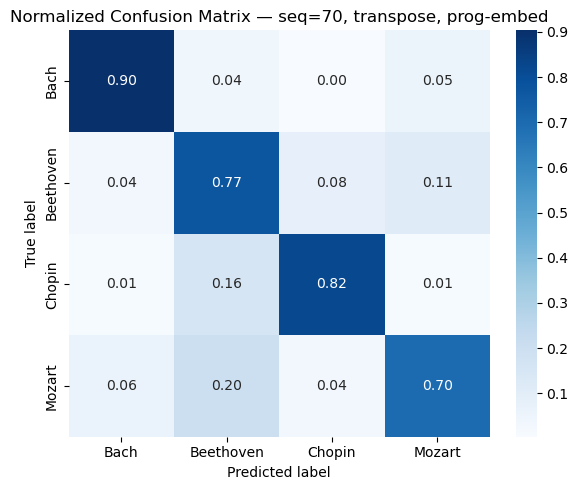

In [4]:
# --- Cell 3: Evaluate & Plot Confusion Matrix ---
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import tensorflow as tf

# If loading a saved model instead of using the one just trained:
# model = tf.keras.models.load_model("final_seq70_model.keras")

# Evaluate
loss, acc = model.evaluate([Xn_test, Xp_test], y_test, verbose=0)
print(f"Test Accuracy: {acc:.4f}")
print(f"Test Loss: {loss:.4f}")

# Predictions
y_pred_probs = model.predict([Xn_test, Xp_test])
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, normalize='true')

# Plot
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.title("Normalized Confusion Matrix — seq=70, transpose, prog-embed")
plt.tight_layout()
plt.show()
